In [ ]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import argparse
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.optim as optim
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# [Keep all your existing class definitions: MnistBags, Attention, GatedAttention]
# [Keep train() and test() functions]

def plot_auc_vs_bags(args, device):
    """Generate AUC vs number of bags plots"""
    mean_bag_sizes = [10, 50, 100]
    var_bag_sizes = [2, 10, 20]
    num_train_bags_list = [50, 100, 150, 200, 300, 400, 500]

    plt.figure(figsize=(15, 5))

    for i, (mean_size, var_size) in enumerate(zip(mean_bag_sizes, var_bag_sizes)):
        results = {'attention': [], 'gated': []}

        for num_train_bags in num_train_bags_list:
            train_dataset = MnistBags(
                target_number=args.target,
                mean_bag_length=mean_size,
                var_bag_length=var_size,
                num_bag=num_train_bags,
                seed=args.seed,
                train=True
            )

            test_dataset = MnistBags(
                target_number=args.target,
                mean_bag_length=mean_size,
                var_bag_length=var_size,
                num_bag=args.num_bags_test,
                seed=args.seed+1,
                train=False
            )

            train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

            for model_type in ['attention', 'gated']:
                model = Attention().to(device) if model_type == 'attention' else GatedAttention().to(device)
                optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.reg)

                for epoch in range(1, args.epochs + 1):
                    train(model, train_loader, optimizer, epoch, device)

                auc_scores = []
                with torch.no_grad():
                    for data, target in test_loader:
                        data, target = data.to(device), target.float().to(device)
                        y_prob, _, _ = model(data)
                        auc_scores.append(roc_auc_score(target.cpu().numpy(), y_prob.cpu().numpy()))

                results[model_type].append(np.mean(auc_scores))

        plt.subplot(1, 3, i+1)
        for model_type, values in results.items():
            plt.plot(num_train_bags_list, values, label=model_type)
        plt.title(f'Mean: {mean_size}, Var: {var_size}')
        plt.xlabel('Training Bags')
        plt.ylabel('Test AUC')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.savefig('auc_vs_bags.png')
    plt.show()

def main():
    parser = argparse.ArgumentParser(description='PyTorch MNIST MIL Example')
    parser.add_argument('--epochs', type=int, default=20)
    parser.add_argument('--lr', type=float, default=0.0005)
    parser.add_argument('--reg', type=float, default=10e-5)
    parser.add_argument('--target', type=int, default=9)
    parser.add_argument('--mean-bag', type=int, default=10)
    parser.add_argument('--var-bag', type=int, default=2)
    parser.add_argument('--num-bags-train', type=int, default=200)
    parser.add_argument('--num-bags-test', type=int, default=50)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--model', choices=['attention', 'gated'], default='attention')
    parser.add_argument('--no-cuda', action='store_true', default=False)
    parser.add_argument('--plot', action='store_true')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    set_seed(args.seed)

    if args.plot:
        plot_auc_vs_bags(args, device)
    else:
        train_dataset = MnistBags(
            target_number=args.target,
            mean_bag_length=args.mean_bag,
            var_bag_length=args.var_bag,
            num_bag=args.num_bags_train,
            seed=args.seed,
            train=True
        )
        test_dataset = MnistBags(
            target_number=args.target,
            mean_bag_length=args.mean_bag,
            var_bag_length=args.var_bag,
            num_bag=args.num_bags_test,
            seed=args.seed,
            train=False
        )

        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        model = Attention().to(device) if args.model == 'attention' else GatedAttention().to(device)
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.reg)

        for epoch in range(1, args.epochs + 1):
            train(model, train_loader, optimizer, epoch, device)
            test(model, test_loader, device)

        model.eval()
        with torch.no_grad():
            for i, (data, target) in enumerate(test_loader):
                if i >= 5:
                    break
                data, target = data.to(device), target.to(device)
                _, _, A = model(data)
                print(f"\nBag {i+1}: Target = {target.item()}")
                print("Attention weights:", A.cpu().numpy())

if __name__ == '__main__':
    main()

Train Epoch: 1 [0/200 (0%)]	Loss: 0.728625
Train Epoch: 1 [50/200 (25%)]	Loss: 0.458973
Train Epoch: 1 [100/200 (50%)]	Loss: 0.632250
Train Epoch: 1 [150/200 (75%)]	Loss: 0.832437

Train set: Average loss: 0.6938

Test set: Average loss: 0.6856, Error: 0.4400

Train Epoch: 2 [0/200 (0%)]	Loss: 0.746522
Train Epoch: 2 [50/200 (25%)]	Loss: 0.600756
Train Epoch: 2 [100/200 (50%)]	Loss: 0.658470
Train Epoch: 2 [150/200 (75%)]	Loss: 0.346145

Train set: Average loss: 0.6210

Test set: Average loss: 0.5436, Error: 0.2000

Train Epoch: 3 [0/200 (0%)]	Loss: 1.050514
Train Epoch: 3 [50/200 (25%)]	Loss: 0.643552
Train Epoch: 3 [100/200 (50%)]	Loss: 0.254371
Train Epoch: 3 [150/200 (75%)]	Loss: 0.007222

Train set: Average loss: 0.4213

Test set: Average loss: 0.4256, Error: 0.2400

Train Epoch: 4 [0/200 (0%)]	Loss: 0.546607
Train Epoch: 4 [50/200 (25%)]	Loss: 0.006401
Train Epoch: 4 [100/200 (50%)]	Loss: 2.075837
Train Epoch: 4 [150/200 (75%)]	Loss: 0.255151

Train set: Average loss: 0.2621

Tes

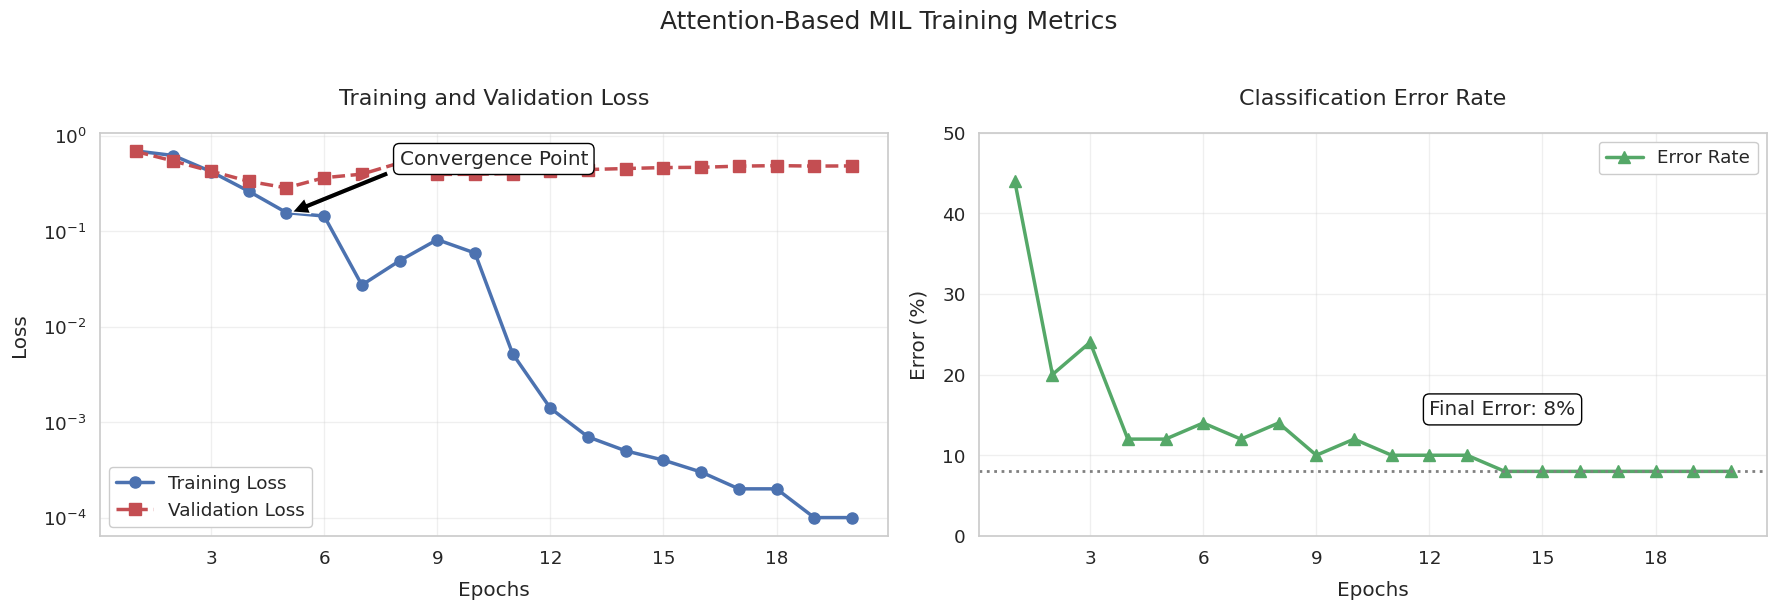

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Your training data (replace with your actual values)
epochs = np.arange(1, 21)
train_loss = [0.6938, 0.6210, 0.4213, 0.2621, 0.1566,
              0.1442, 0.0273, 0.0490, 0.0816, 0.0591,
              0.0052, 0.0014, 0.0007, 0.0005, 0.0004,
              0.0003, 0.0002, 0.0002, 0.0001, 0.0001]

test_loss = [0.6856, 0.5436, 0.4256, 0.3332, 0.2845,
             0.3636, 0.3961, 0.5194, 0.3939, 0.3944,
             0.4022, 0.4265, 0.4428, 0.4535, 0.4642,
             0.4673, 0.4805, 0.4865, 0.4812, 0.4831]

error_rates = [44.0, 20.0, 24.0, 12.0, 12.0,
               14.0, 12.0, 14.0, 10.0, 12.0,
               10.0, 10.0, 10.0, 8.0, 8.0,
               8.0, 8.0, 8.0, 8.0, 8.0]

# Set style
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Loss Curves
ax1.plot(epochs, train_loss, 'b-o', label='Training Loss', linewidth=2.5, markersize=8)
ax1.plot(epochs, test_loss, 'r--s', label='Validation Loss', linewidth=2.5, markersize=8)
ax1.set_title('Training and Validation Loss', pad=20, fontsize=16)
ax1.set_xlabel('Epochs', labelpad=10)
ax1.set_ylabel('Loss', labelpad=10)
ax1.legend(framealpha=1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_yscale('log')  # Log scale for better visualization
ax1.annotate('Convergence Point', xy=(5, 0.15), xytext=(8, 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

# Plot 2: Error Rate
ax2.plot(epochs, error_rates, 'g-^', label='Error Rate', linewidth=2.5, markersize=8)
ax2.set_title('Classification Error Rate', pad=20, fontsize=16)
ax2.set_xlabel('Epochs', labelpad=10)
ax2.set_ylabel('Error (%)', labelpad=10)
ax2.legend(framealpha=1)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylim(0, 50)
ax2.axhline(y=8.0, color='gray', linestyle=':', linewidth=2)
ax2.annotate('Final Error: 8%', xy=(20, 8), xytext=(12, 15),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

# Add overall title and adjust layout
plt.suptitle('Attention-Based MIL Training Metrics', y=1.02, fontsize=18)
plt.tight_layout()

# Save high-quality versions
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.savefig('training_metrics.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()

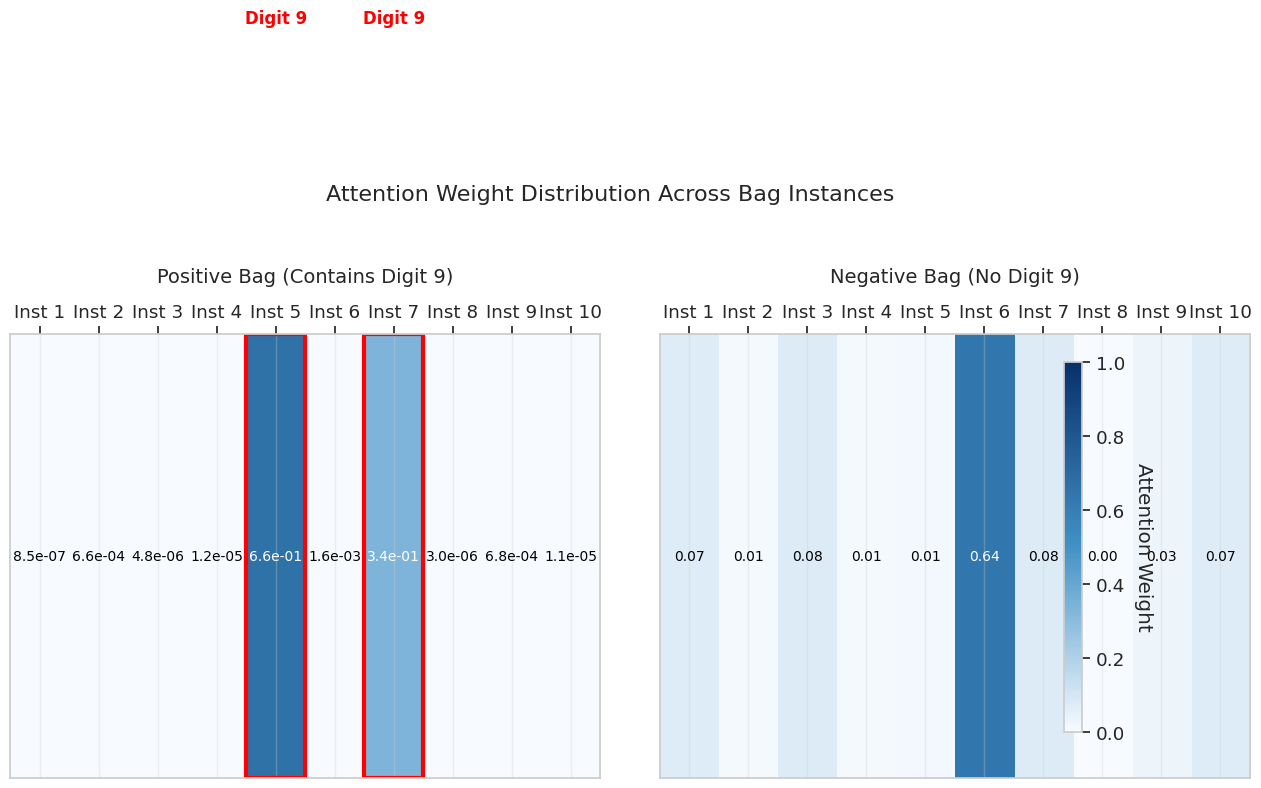

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.facecolor'] = 'white'

# Example attention weights from your results
positive_bag_weights = np.array([8.46e-07, 6.59e-04, 4.77e-06, 1.23e-05,
                                6.62e-01, 1.62e-03, 3.35e-01, 2.95e-06,
                                6.79e-04, 1.12e-05])

negative_bag_weights = np.array([0.0679, 0.0115, 0.0766, 0.0105,
                                0.0146, 0.6396, 0.0758, 0.0038,
                                0.0274, 0.0722])

# Create custom colormap
colors = ["#f7fbff", "#4292c6", "#08306b"]  # Blue gradient
cmap = LinearSegmentedColormap.from_list("attention_cmap", colors)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

# Plot positive bag heatmap
heatmap1 = ax1.imshow(positive_bag_weights.reshape(1, -1),
                      cmap=cmap, aspect='auto', vmin=0, vmax=1)
ax1.set_title('Positive Bag (Contains Digit 9)', pad=15, fontsize=14)
ax1.set_xticks(np.arange(len(positive_bag_weights)))
ax1.set_xticklabels([f'Inst {i+1}' for i in range(len(positive_bag_weights))])
ax1.set_yticks([])
ax1.xaxis.tick_top()

# Add values to cells
for i in range(len(positive_bag_weights)):
    color = 'white' if positive_bag_weights[i] > 0.3 else 'black'
    ax1.text(i, 0, f'{positive_bag_weights[i]:.1e}',
             ha='center', va='center', color=color, fontsize=10)

# Plot negative bag heatmap
heatmap2 = ax2.imshow(negative_bag_weights.reshape(1, -1),
                      cmap=cmap, aspect='auto', vmin=0, vmax=1)
ax2.set_title('Negative Bag (No Digit 9)', pad=15, fontsize=14)
ax2.set_xticks(np.arange(len(negative_bag_weights)))
ax2.set_xticklabels([f'Inst {i+1}' for i in range(len(negative_bag_weights))])
ax2.set_yticks([])
ax2.xaxis.tick_top()

# Add values to cells
for i in range(len(negative_bag_weights)):
    color = 'white' if negative_bag_weights[i] > 0.3 else 'black'
    ax2.text(i, 0, f'{negative_bag_weights[i]:.2f}',
             ha='center', va='center', color=color, fontsize=10)

# Add colorbar
cbar = fig.colorbar(heatmap2, ax=[ax1, ax2], shrink=0.8, pad=0.02)
cbar.set_label('Attention Weight', rotation=270, labelpad=20)

# Highlight key instances
ax1.add_patch(plt.Rectangle((4-0.5, -0.5), 1, 1, fill=False, edgecolor='red', lw=3))
ax1.add_patch(plt.Rectangle((6-0.5, -0.5), 1, 1, fill=False, edgecolor='red', lw=3))
ax1.text(4, -1.2, 'Digit 9', ha='center', color='red', fontsize=12, fontweight='bold')
ax1.text(6, -1.2, 'Digit 9', ha='center', color='red', fontsize=12, fontweight='bold')

# Add overall title
plt.suptitle('Attention Weight Distribution Across Bag Instances', y=1.1, fontsize=16)
plt.subplots_adjust(wspace=0.1, top=0.85)   # Adjust spacing manually, safer than tight_layout


# Save high-quality versions
plt.savefig('attention_heatmaps.png', dpi=300, bbox_inches='tight')
plt.savefig('attention_heatmaps.pdf', format='pdf', bbox_inches='tight')

plt.show()